<a href="https://colab.research.google.com/github/kircherlab/MPRAsnakeflow_tutorial/blob/main/tutorial_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
import matplotlib.pyplot as plt
import os
import cv2

# MPRAsnakeflow experiment tutorial

This notebook is used to generate activity measurements from DNA, barcode counts. The input file of the assignment workflow is needed to associate the barcodes to designed oligos.

After going through the pre-requirements we will cover the config file, run MPRAsnakeflow and look at interesting results like the correlation of the DNA and RNA counts among the replicates. This is useful in practice to check if the data preparation went well, because if the resulting data is not correlating between replicates, problems during the experiment will introduce a bias in the results of our analysis that we would like to know about.

## Pre-requirements

### Docker/uDocker/apptainer

When running locally you need to install `docker` or `apptainer`. For running it remotly on google colab `udocker` in colab from github.com/drengskapur/docker-in-colab works nicely.

We try to atomatically find out what you need:

In [2]:
tutorial_container = "visze/mprasnakeflow_tutorial:0.1.0"
docker= False
apptainer = False

docker = !docker --help &>/dev/null; if [ $? -eq 0 ]; then echo 1; else echo 0; fi
docker = bool(int(docker[0]))
apptainer = !apptainer --help &>/dev/null; if [ $? -eq 0 ]; then echo 1; else echo 0; fi
apptainer = bool(int(apptainer[0]))

if docker:
    print("Docker is installed! We will use Docker to run MPRAsnakeflow")
elif apptainer:
    print("Apptainer is installed! We will use Apptainer to run MPRAsnakeflow")
else:
    print("Neither Docker nor Apptainer is installed. We assume you run the tutorial on colab and we will install uDocker for colab")

Apptainer is installed! We will use Apptainer to run MPRAsnakeflow


When neither Docker nor Apptainer is installed we will install udocjer for colab now.

In [3]:
def udocker_init():
    import os
    if not os.path.exists("/home/user"):
        !pip install udocker > /dev/null
        !udocker --allow-root install > /dev/null
        !useradd -m user > /dev/null
    print(f'Docker-in-Colab 1.1.0\n')
    print(f'Usage:     udocker("--help")')
    print(f'Examples:  https://github.com/indigo-dc/udocker?tab=readme-ov-file#examples')

    def execute(command: str):
        user_prompt = "\033[1;32muser@pc\033[0m"
        print(f"{user_prompt}$ udocker {command}")
        !su - user -c "udocker $command"

    return execute

if not docker and not apptainer:
    udocker = udocker_init()

We define a general function to run our MPRAsnakeflow tutorial container that will check if docker, apptainer or uDocker has to be run. It will also bind your data directory `${{PWD}}/MPRAsnakeflow_tutorial` (will be dowloaded later) to `/data/run` within the container and defines this as working directory.

In [4]:
def runContainer(command):
    user_prompt = "\033[1;32muser@pc\033[0m"
    if docker:
        print(f"{user_prompt}$ docker run -v=${{PWD}}/MPRAsnakeflow_tutorial:/data/run --workdir /data/run {tutorial_container} {command}")
        !docker run -v=${{PWD}}/MPRAsnakeflow_tutorial:/data/run --workdir /data/run {tutorial_container} {command}
    elif apptainer:
        print(f"apptainer run -B=${{PWD}}/MPRAsnakeflow_tutorial:/data/run --cwd /data/run mprasnakeflow_tutorial.sif {command}")
        !apptainer run -B=${{PWD}}/MPRAsnakeflow_tutorial:/data/run --cwd /data/run mprasnakeflow_tutorial.sif {command}
    else:
        udocker(f"run -v=${{PWD}}/MPRAsnakeflow_tutorial:/data/run --workdir /data/run mprasnakeflow_tutorial {command}")

### Test data

The data used in this tutorial is present in the github repository. We will dowload it using git so that it is also present within a colab environment.

In [5]:
%%bash
git clone https://github.com/kircherlab/MPRAsnakeflow_tutorial.git

Cloning into 'MPRAsnakeflow_tutorial'...


### snakemake

MPRAsnakeflow and its software dependencies is packed in the official snakemake v8.20.3 container and you can find it on dockerhub wih the tag [`visze/mprasnakeflow_tutorial:0.1.0`](https://hub.docker.com/r/visze/mprasnakeflow_tutorial).

In [6]:
if docker:
    print(f"docker pull {tutorial_container}")
    !docker pull "{tutorial_container}"
    print(f"docker create --name=mprasnakeflow_tutorial {tutorial_container}")
    !docker create --name=mprasnakeflow_tutorial "{tutorial_container}" > /dev/null
elif apptainer:
    print(f"apptainer pull mprasnakeflow_tutorial.sif docker://{tutorial_container}")
    !apptainer pull mprasnakeflow_tutorial.sif docker://{tutorial_container} > /dev/null
else:
    udocker(f"pull {tutorial_container}")
    udocker(f"create --name=mprasnakeflow_tutorial {tutorial_container}")

apptainer pull mprasnakeflow_tutorial.sif docker://visze/mprasnakeflow_tutorial:0.1.0
INFO:    Using cached SIF image


Try to run `snakemake --version` in docker:

In [7]:
runContainer("snakemake --version")

apptainer run -B=${PWD}/MPRAsnakeflow_tutorial:/data/run --cwd /data/run mprasnakeflow_tutorial.sif snakemake --version
8.20.3+0.ge9ce4a3c.dirty


## Experiment Workflow

For the experiment step, where the counts per oligo are calculated, we need all the files in the `example_data/counts` folder, as well as the config file and the barcode assignment file, which is the output of the assignment step (but also stored under `example_data/counts`).

We investigated the assignment file in the association tutorial. This table is now used to count the number of observed barcodes for each target sequence.

We can take a look at the input files, to understand what we later have to gve the MPRAsnakeflow pipeline via a config file. Each count experiment, in our case, is described using three files (the paths of which are in the `experiment.csv` file): forward reads, reverse reads, and UMIs. Note that the UMIs are optional, and serve to deduplicate barcodes with overdispersed counts due to preferential amplification related to GC content or library preparation steps. From one of the UMI read files, we can see that indeed our UMI length is 16:

In [8]:
print("\nAverage length of a UMI:")
!zcat "MPRAsnakeflow_tutorial/example_data/counts/dna-1_S1_R2_001.fastq.gz" | awk 'NR % 4 == 2 {{sum += length($$0)}} END {{print sum*4/NR}}'


Average length of a UMI:
16


We can also check the length of the barcode, which should be 15:

In [9]:
print("\nAverage length of a barcode:")
!zcat "MPRAsnakeflow_tutorial/example_data/counts/dna-1_S1_R1_001.fastq.gz" | awk 'NR % 4 == 2 {{sum += length($$0)}} END {{print sum*4/NR}}'


Average length of a barcode:
15


## Run MPRAsnakeflow




### Snakemake

Before we come to more MPRAsnakeflow pipeline specific things we quickly want to introduce the snakemake workflow management system. A workflow management system, also like nextflow or cwl, is a tool to create reproducible and scalable data analyses. Snakemake workflows are described via a human readable, Python based language. They can be seamlessly scaled to server, cluster, grid and cloud environments, without the need to modify the workflow definition. Finally, Snakemake workflows can entail a description of required software, which will be automatically deployed to any execution environment.

Each step in snakemake is defined as a `rule`. Which has a `input`, `output` and a mostly `shell` command. The `input` and `output` are files that are used as input and output for the rule. The `shell` command is the command that is executed to create the output file from the input file. There are other commands like `conda`, `params`, `log`, `threads`, `resources` that can be used to define the rule.

E.g. here is an example rule `assigned_counts_combine_replicates` of MPRAsnakeflow, which combines counts of replicates into one final count. In short: merging counts of replicates. The ruzle takes as ainput a tab separated file with all counts in it per condition. And the python script that will merge it `combine_replicates.py`. Path names in curly brackets like  `{project}` or `{assignment}` is a wildcard and the name will be the project, assignment name etc that is configured in the config files.  Finally the `shell` command takes the python script, the inputs and runs it creating the output and logs.

```python
rule assigned_counts_combine_replicates:
    """
    Combine replicates of master table by summing counts up and using also the average.
    """
    conda:
        "../envs/python3.yaml"
    input:
        master_table="results/experiments/{project}/assigned_counts/{assignment}/{config}/{condition}_{allreps_or_threshold}_merged.tsv.gz",
        script=getScript("count/combine_replicates.py"),
    output:
        "results/experiments/{project}/assigned_counts/{assignment}/{config}/{condition}_{allreps_or_threshold}_merged.combined.tsv.gz",
    params:
        label_file=lambda wc: (
            "--labels %s" % config["experiments"][wc.project]["label_file"]
            if "label_file" in config["experiments"][wc.project]
            else ""
        ),
    log:
        temp(
            "results/logs/assigned_counts/combine_replicates.{project}.{condition}.{config}.{assignment}.{allreps_or_threshold}.log"
        ),
    shell:
        """
        python {input.script} \
        --input {input.master_table} \
        {params.label_file} \
        --output {output}  &> {log}
        """
```


When running snakemake you need to specify where your worflow is, basically the main `Snakefile` of it. By default, Snakemake will search for ‘Snakefile’, ‘snakefile’, ‘workflow/Snakefile’, ‘workflow/snakefile’ beneath the current working directory, in this order. Then you do not have to use this command. But practically your workflow, here MPRAsnakeflow, might live somewhere else and you want to run the workflow in a different directory where you want to produce results. Then you need to specify the `--snakefile` parameter to the MPRAsnakeflow file in `workflow/Snakefile`. Otherwise you ahve to check/copy the workflow in every "run" rirectory which is not practically. Usually you start snakemake in the directory where you want to produce results.

### The config file

The heart of your workflow run is the config file. You can specify it via `--configfile`. It is in `yaml` or `json` format. It contains all the parameters and input files that are used in the workflow.

The config file has many parameters. But most of them have a default well, based on best practice and you don't have to specify them. But you can overwrite them if you want. Config files are first validated using json schema. If your config file is not correct MPRAsnakeflow will tell you what is missing or wrong and stop. Naming, parameters etc. might change from MPRAsnakeflow version and you might have to update your config file if you run a new version of MPRAsnakeflow. An extensive documentation of the config file can be found in the [MPRAsnakeflow documentation](https://mprasnakeflow.readthedocs.io/en/development/config.html).

Here is the config file that we will use for running the experiment tutorial.



```yaml
---
experiments:
  experimentMPRAworkshop:
    bc_length: 15
    umi_length: 16
    data_folder: example_data/counts
    experiment_file: example_data/experiment.csv
    assignments:
      MPRAworkshop:
        type: file
        assignment_file: example_data/assignment/assignment_barcodes.default.tsv.gz
    label_file: example_data/design/workshop_labels.tsv
    configs:
      default: {}
      tutorialConfig:
        filter:
          bc_threshold: 5
          DNA:
            min_counts: 1
          RNA:
            min_counts: 1
```

The previous block shows the part of the config file that concerns the experiment part. Since assignment and experiment part can be run independently the `bc_length` needs to be set again.

The `experiment_file` holds the path to the file of the experiment table (i.e. condition, replicate and name of read files given).

Because we run the experiment workflow we start with `experiments`. Then a list with possible names of experiments will follow. Here we have just one: `experimentMPRAworkshop`. The whole config file has the minimal information, which is needed by MPRAsnakeflow (except for `configs`, see later). This is the barcode length `bc_length` and the UMI length `umi_length` which we calculated previously. Then a link to folder `data_folder` where all fastqs of the experiment are. What conditions, replicates and belonging fastq files we have is stored in the the `experiment_file`.


As a sanity check and to understand where these values come from, we will take a look at if the information matches our input files. We used 15 bp adapters for this MPRA experiment, which were added at both ends of each designed oligo. The ``alignment_start`` configuration refers to these adapters as our actual target sequences only starts after the 15 bp of adapter sequence.

In [10]:
adapter_length=15

print("\nAverage length of a barcode:")
!zcat "MPRAsnakeflow_tutorial/example_data/assignment/assoc_bc.fastq.gz" | awk 'NR % 4 == 2 {{sum += length($$0)}} END {{print sum*4/NR}}'

print("\nAverage length of a target sequence (oligo length - 2 x adapter):")
seq_length_with_bc = !cat "MPRAsnakeflow_tutorial/example_data/design/workshop_design.fa" | awk 'NR % 4 == 2 {{sum +=length($$0)}} END {{print sum*4/NR}}'
seq_length_with_bc = int(seq_length_with_bc[0])
seq_length = seq_length_with_bc - 2*adapter_length
print(seq_length)


Average length of a barcode:
15

Average length of a target sequence (oligo length - 2 x adapter):
200


### MPRAsnakeflow tutorial profile

Snakemake can make use of profiles to pre-configure command-line-interfaces as well as ressources and number of threads as default or per rule. A profile has to be stored (on Linux) in the folder `$HOME/.config/snakemake` or `/etc/xdg/snakemake`. It can be activated by using the `--profile` option in the snakemake command. In addition you can set an environment variable `SNAKEMAKE_PROFILE`, e.g. by specifying export `SNAKEMAKE_PROFILE=myprofile` in your `~/.bashrc` to use the profile by default. In addition a specific workflow profile can be set using `--workflow-profile path_to_your_profile`. E.g. we pre-defined a [workflow profile for MPRAsnakeflow](https://github.com/kircherlab/MPRAsnakeflow/blob/development/profiles/default/config.yaml) adding ressources to each rule with some additional commands for the [snakemake excecutor plugin slum](https://snakemake.github.io/snakemake-plugin-catalog/plugins/executor/slurm.html).

For more information on snakemake using profiles please have a look [snakemke profile documentation](https://snakemake.readthedocs.io/en/stable/executing/cli.html#profiles)

For the MPRAsnakeflow tutorial we will use the profile `mprasnakeflow` which is stored in the folder `/etc/xdg/snakemake` within the container and the `SNAKEMAKE_PROFILE=mprasnakeflow` is already set. Have a look at the variable and the profile:

In [11]:
runContainer("cat /etc/xdg/snakemake/mprasnakeflow/config.yaml")

apptainer run -B=${PWD}/MPRAsnakeflow_tutorial:/data/run --cwd /data/run mprasnakeflow_tutorial.sif cat /etc/xdg/snakemake/mprasnakeflow/config.yaml
---
snakefile: /data/MPRAsnakeflow/workflow/Snakefile
software-deployment-method: conda
conda-prefix: /data/conda_envs
cores: 1
set-threads:
  assignment_mapping_bbmap: 10


You see that we already defined where the MPRASsnkeflow `Snakefile` is and `--snakefile` is not necessary. Also all software packages are installed alrady in the container using conda and we enable this software deployment method and tell snakemake where the conda environments live (the default will be your exceuction folder under `.snamemake/conda`). Also the `--cores/-c` option is not necessary anymore and snakemake just needs your configuration file of the workflow using the command `--configfile`

### Run the workflow

First we run a dry-run to see what will be executed using `-n` and `--quiet rules` to see only the overview of excecuted rules and not each rule command individually. The most important part is setting the config file via `-configfile config_experiment.yaml`

In [12]:
# MPRAsnakeflow_tutorial must be accessable and writable for all (and docker)
!chmod ugo+rwx MPRAsnakeflow_tutorial
# Run MPRAsnakeflow
runContainer("snakemake --configfile config_experiment.yaml -n --quiet rules")

apptainer run -B=${PWD}/MPRAsnakeflow_tutorial:/data/run --cwd /data/run mprasnakeflow_tutorial.sif snakemake --configfile config_experiment.yaml -n --quiet rules
Using profile mprasnakeflow for setting default command line arguments.
host: pmn-bih-cfbi-20
Building DAG of jobs...
Job stats:
job                                                             count
------------------------------------------------------------  -------
all                                                                 1
assigned_counts_assignBarcodes                                     12
assigned_counts_combine_replicates                                  4
assigned_counts_combine_replicates_barcode_output                   2
assigned_counts_dna_rna_merge                                       6
assigned_counts_filterAssignment                                    1
assigned_counts_make_master_tables                                  2
counts_dna_rna_merge_counts                                        12
counts_f

You see a list of rules and how often this rule is executed debending on the input file. A short summary of each rule is in the [MPRAsnakeflow documentation](https://mprasnakeflow.readthedocs.io/en/latest/experiment.html#rules).

Now let's run snakemake using 10 cores. When you add the `-p` flag you will see the exact code that is executed in each rule. But we ommit this here beacuse it is a lot of output.

In [13]:
runContainer("snakemake --configfile config_experiment.yaml -c 10")

apptainer run -B=${PWD}/MPRAsnakeflow_tutorial:/data/run --cwd /data/run mprasnakeflow_tutorial.sif snakemake --configfile config_experiment.yaml -c 10
Using profile mprasnakeflow for setting default command line arguments.
Assuming unrestricted shared filesystem usage.
host: pmn-bih-cfbi-20
Building DAG of jobs...
Using shell: /usr/bin/bash
Provided cores: 10
Rules claiming more threads will be scaled down.
Singularity containers: ignored
Job stats:
job                                                             count
------------------------------------------------------------  -------
all                                                                 1
assigned_counts_assignBarcodes                                     12
assigned_counts_combine_replicates                                  4
assigned_counts_combine_replicates_barcode_output                   2
assigned_counts_dna_rna_merge                                       6
assigned_counts_filterAssignment                       

## Experiment results

Let's take a look at the files in the experiment results folder!

In [14]:
results_dir = "MPRAsnakeflow_tutorial/results/experiments"
!ls -R "{results_dir}"

MPRAsnakeflow_tutorial/results/experiments:
experimentMPRAworkshop

MPRAsnakeflow_tutorial/results/experiments/experimentMPRAworkshop:
assigned_counts  qc_report.HepG2.MPRAworkshop.default.html
assignment	 qc_report.HepG2.MPRAworkshop.tutorialConfig.html
counts		 statistic

MPRAsnakeflow_tutorial/results/experiments/experimentMPRAworkshop/assigned_counts:
MPRAworkshop

MPRAsnakeflow_tutorial/results/experiments/experimentMPRAworkshop/assigned_counts/MPRAworkshop:
HepG2_1.merged.config.default.tsv.gz
HepG2_1.merged.config.tutorialConfig.tsv.gz
HepG2_1_DNA_final_counts.config.default.tsv.gz
HepG2_1_DNA_final_counts.config.tutorialConfig.tsv.gz
HepG2_1_RNA_final_counts.config.default.tsv.gz
HepG2_1_RNA_final_counts.config.tutorialConfig.tsv.gz
HepG2_2.merged.config.default.tsv.gz
HepG2_2.merged.config.tutorialConfig.tsv.gz
HepG2_2_DNA_final_counts.config.default.tsv.gz
HepG2_2_DNA_final_counts.config.tutorialConfig.tsv.gz
HepG2_2_RNA_final_counts.config.default.tsv.gz
HepG2_2_RNA_final_co

We can take a look at the amount of barcodes that have been removed due to UMI collision, by checking how many unique BC x UMI combinations we have in our data. (We are now checking the RNA counts in replicate 1, but we should look at both DNA and RNA counts in all three replicates.)

In [15]:
print("First few lines of a count file, where column 1 contains the barcode, 2 the UMI and 3 the count.")
!zcat "{results_dir}"/experimentMPRAworkshop/counts/HepG2_1_RNA_filtered_counts.tsv.gz | awk 'NR <= 10 {{print}}'

print("\nAmount of total BC x UMI combinations:")
!zcat "{results_dir}"/experimentMPRAworkshop/counts/HepG2_1_RNA_filtered_counts.tsv.gz | wc -l

print("\nAmount of duplicate BC x UMI combinations (the file is sorted):")
!zcat "{results_dir}"/experimentMPRAworkshop/counts/HepG2_1_RNA_filtered_counts.tsv.gz | uniq -d | wc -l

First few lines of a count file, where column 1 contains the barcode, 2 the UMI and 3 the count.
AAAAAAAAAAAAAAA	CGAAGTACACTTTCCG	1
AAAAAAAAAAAAAAA	TATAGTAAACACGCCC	1
AAAAAAAAAAAAAGG	CGTGAGCAGGATTAAG	1
AAAAAAAAAACAAGT	CTATCCGCACTGTGTC	1
AAAAAAAAAACCCAA	TTCCTAGGGACAGTCC	1
AAAAAAAAAAGATGC	GGAGCATGTAATGGGT	1
AAAAAAAAAAGCTGC	AAGATATACGGACGAT	1
AAAAAAAAAAGCTGC	AGAGGTTAGAAGGGCA	1
AAAAAAAAAAGCTGC	ATATGGACCGCCCTGG	1
AAAAAAAAAAGCTGC	CATGCACCCTGCATAA	1

Amount of total BC x UMI combinations:
871819

Amount of duplicate BC x UMI combinations (the file is sorted):
0


There are no collisions, indicating that this subset of the data is of high quality. Great!

The count files are then joined with the assignment file (the output of the assignment step) to assign counts to oligos. The barcode counts are then aggregated over the oligos. This is done within MPRAsnakeflow with additional filter steps, but to give you a feeling of what's happening we give you some simplified code below:

In [16]:
counts_rep1 = os.path.join(results_dir, "experimentMPRAworkshop/assigned_counts/MPRAworkshop/HepG2_1.merged.config.tutorialConfig.tsv.gz")
assignment = "MPRAsnakeflow_tutorial/example_data/assignment/assignment_barcodes.default.tsv.gz"

print("Joining the assignment and the counts of replicate 1:\n\nBarcode\toligo\tDNA\tRNA")
!join <(zcat {assignment}) <(zcat {counts_rep1}) -t $'\t' | cut -f 1,2,5-6 | awk 'NR <= 10 {{print}}'

print("\nAggregating the barcodes over oligos and the counts of replicate 1:\n\noligo\tDNA\tRNA")
!join <(zcat {assignment}) <(zcat {counts_rep1}) -t $'\t' | cut -f 1,2,5-6 | sort -k2,2 | \
 awk -v OFS="\t" '{{if ($$2 == prev) {{dna += $$3; rna += $$4}} else {{ if (NR > 1) print prev,dna,rna; prev=$$2; dna=$$3;rna=$$4}}}}' | awk 'NR <= 10 {{print}}'

Joining the assignment and the counts of replicate 1:

Barcode	oligo	DNA	RNA
AAAAAAAAATCGATC	oligo_006917	2	3
AAAAAAAACACATGA	oligo_005412	11	4
AAAAAAAACAGTAAG	oligo_006290	4	3
AAAAAAAACCAAATA	oligo_189277	3	2
AAAAAAAACGAACAG	oligo_005299	4	1
AAAAAAAAGAATTAC	oligo_144932	4	4
AAAAAAAAGAGTAGT	oligo_006091	7	10
AAAAAAACCGCACAT	oligo_005747	1	4
AAAAAAAGACCTAAG	oligo_006429	1	4
AAAAAAAGAGGTAAA	oligo_006350	4	6

Aggregating the barcodes over oligos and the counts of replicate 1:

oligo	DNA	RNA
oligo_002500	23	41
oligo_002501:oligo_002502	12	26
oligo_002503	14	24
oligo_002504	1	2
oligo_002505	24	41
oligo_002506	7	15
oligo_002507	11	20
oligo_002508	11	29
oligo_002510	15	31
oligo_002511	24	30


In the next steps, barcodes are already aggregated to their oligos/targets.  
  
We will have a look at the correlation plots between the replicates for DNA and RNA now. Typically, we will sequence RNA counts deeper than DNA -- because of the larger dynamic range of RNA. We therefore expect that the correlation of RNA counts is higher than that of the DNA. Our example data shows this trend as well.

We have a correlation of DNA counts per insert between the replicates of 0.27 and 0.31. This correlation is for a subset of the complete MPRA experiment. The shown output uses the user set minThreshold for removing barcodes with too few counts. In order to see the influence of the parameter another plot is generated without this threshold.

With the threshold of 5 barcodes per oligo and at least one DNA and RNA count
- DNA correlation: 0.28 - 0.31
- RNA correlation: 0.68 - 0.70

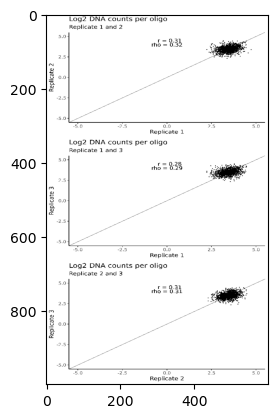

In [17]:
dna_pairwise = cv2.imread(f'{results_dir}/experimentMPRAworkshop/statistic/assigned_counts/MPRAworkshop/tutorialConfig/HepG2_DNA_pairwise_minThreshold.png')

dna_pairwise_resize = cv2.resize(dna_pairwise, (600, 1000))

plt.imshow(dna_pairwise_resize)
plt.show()

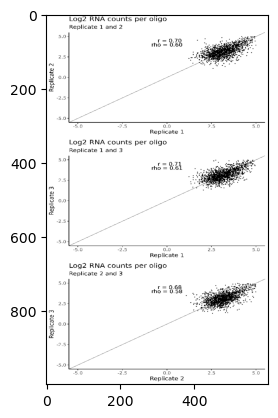

In [18]:
rna_pairwise = cv2.imread(f'{results_dir}/experimentMPRAworkshop/statistic/assigned_counts/MPRAworkshop/tutorialConfig/HepG2_RNA_pairwise_minThreshold.png')

rna_pairwise_no_thresh_resize = cv2.resize(rna_pairwise, (600, 1000))

plt.imshow(rna_pairwise_no_thresh_resize)
plt.show()

In the following two figures you can see that this trend is continues for a threshold of 10 barcodes per insert.
- DNA correlation: 0.31 - 0.39
- RNA correlation: 0.79 - 0.80

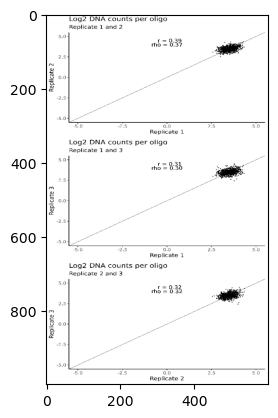

In [19]:
dna_pairwise_no_thresh = cv2.imread(f'{results_dir}/experimentMPRAworkshop/statistic/assigned_counts/MPRAworkshop/default/HepG2_DNA_pairwise_minThreshold.png')

dna_pairwise_no_thresh_resize = cv2.resize(dna_pairwise_no_thresh, (600, 1000))

plt.imshow(dna_pairwise_no_thresh_resize)
plt.show()

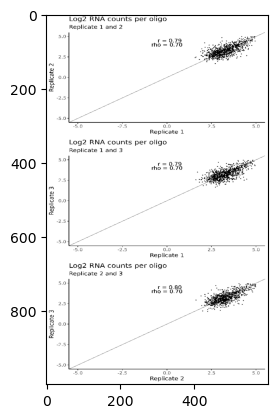

In [20]:
rna_pairwise_no_thresh = cv2.imread(f'{results_dir}/experimentMPRAworkshop/statistic/assigned_counts/MPRAworkshop/default/HepG2_RNA_pairwise_minThreshold.png')

rna_pairwise_no_thresh_resize = cv2.resize(rna_pairwise_no_thresh, (600, 1000))

plt.imshow(rna_pairwise_no_thresh_resize)
plt.show()

Even though it is a small example, the minimal barcode count threshold shows a clear effect on correlation. However, we also note that we are losing a proprotion of oligos with these strict filters and thereby limit the conclusions that we can draw from the data.

Now we want go through the final output of MPRAsnakeflow: the count table of sequences and barcodes together with their aggregated log2 values. Note that there are no statistics calculated at this step yet, the table doesn't say anything about certainty/variance of the activity. The log2 value refers to the log2 ratio of RNA counts over DNA counts for each oligo, which is a measurement of the activity of the target sequence. More on this in the statistical analysis tutorial.

In [21]:
 !zcat {results_dir}/experimentMPRAworkshop/assigned_counts/MPRAworkshop/tutorialConfig/HepG2_allreps_merged.tsv.gz | awk 'NR <= 10 {{print}}'

condition	replicate	name	dna_counts	rna_counts	dna_normalized	rna_normalized	ratio	log2	n_obs_bc
HepG2	1	no_BC	151319	395859	9.92699744895787	9.72217308865842	1.2629236568282	0.33676743	71914
HepG2	1	oligo_002500	23	41	13.5636240116246	9.05169977675417	0.860569715142429	-0.21663602	8
HepG2	1	oligo_002501:oligo_002502	12	26	8.0876267398507	6.56011691137585	1.04597701149425	0.06485114	7
HepG2	1	oligo_002503	14	24	9.43556452982582	6.05549253357771	0.827586206896552	-0.27301849	7
HepG2	1	oligo_002504	1	2	4.71778226491291	3.532370644587	0.96551724137931	-0.05062607	1
HepG2	1	oligo_002505	24	41	14.1533467947387	9.05169977675417	0.824712643678161	-0.27803657	8
HepG2	1	oligo_002506	7	15	8.25611896359759	6.62319495860062	1.03448275862069	0.0489096	4
HepG2	1	oligo_002507	11	20	8.64926748567367	5.88728440764499	0.877742946708464	-0.1881296	6
HepG2	1	oligo_002508	11	29	10.3791209828084	10.2438748693023	1.27272727272727	0.3479233	5


### QC report

We have a QC report for the assigment as well for the experiment workflow. For our run you can find it here:

- [MPRAsnakeflow_tutorial/results/experiments/experimentMPRAworkshop/qc_report.HepG2.MPRAworkshop.default.html](MPRAsnakeflow_tutorial/results/experiments/experimentMPRAworkshop/qc_report.HepG2.MPRAworkshop.default.html) - 10 BC threshold

- [MPRAsnakeflow_tutorial/results/experiments/experimentMPRAworkshop/qc_report.HepG2.MPRAworkshop.tutorialConfig.html](MPRAsnakeflow_tutorial/results/experiments/experimentMPRAworkshop/qc_report.HepG2.MPRAworkshop.tutorialConfig.html) - 5 BC threshold


The QC report gives a nice overview of the experiment run and might be the first thing you will look on. Because we have two configurations you can compare both.

In [22]:
from IPython.display import IFrame

IFrame(src='./MPRAsnakeflow_tutorial/results/experiments/experimentMPRAworkshop/qc_report.HepG2.MPRAworkshop.default.html', width=700, height=600)

IFrame(src='./MPRAsnakeflow_tutorial/results/experiments/experimentMPRAworkshop/qc_report.HepG2.MPRAworkshop.tutorialConfig.html', width=700, height=600)